# Working With Datasets

All of the SHIFT AVIRIS-NG data lives in the dh-shift-curated S3 bucket, located in the ‘aviris’ folder, and is organized by date of the flight. Both the Zarr archives and the original raw data (in /raw) are located here.

Additional campaign raster pre-grid and vector data is available in the dh-shift-curated bucket in their respective folders.

Some example code for working with AVIRIS data is in the ‘dh-shift-shared/notebook-template.ipynb’ notebook. Additional examples are here: https://github.com/marinadunn/SHIFT-STAC-demo; specifically, take a look at this [notebook](https://github.com/dieumynguyen/SHIFT-STAC-demo/blob/main/data_visualization_demo.ipynb).

## Streamlined Xarray Interface to AVIRIS Datasets

We have an experimental capability to access the entire set of AVIRIS gridded mosaics as a single Xarray dataset (that can be subset by space, time, and wavelength). To open the dataset, code like the following (pay careful attention to the open_dataset arguments, position of brackets, quotes, etc.)

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython import display
import warnings
import pandas as pd
warnings.filterwarnings("ignore")

dat = xr.open_dataset("reference://", engine="zarr", backend_kwargs={
    "consolidated": False,
    "storage_options": {"fo": "s3://dh-shift-curated/aviris/v1/gridded/zarr.json"}
})

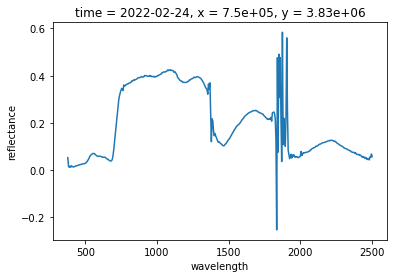

In [2]:
# Select a pixel at a time step and plot the reflectance
dsub = dat.sel(x=750_000, y=3_830_000, time="2022-02-24", method="nearest")
dsub.reflectance.plot()

In [3]:
# Extract a time series for a pixel
dsub = dat.sel(x=750_000, y=3_830_000, method="nearest").reflectance

fig, ax = plt.subplots()
plt.ylabel("reflectance")
plt.xlabel("wavelength")

x = dsub[0].wavelength
line, = ax.plot(x, dsub[0])
ax.set_title(str(pd.Timestamp(dsub.time[0].item())))

def animate(i):
    line.set_ydata(dsub[i])  # update the data
    ax.set_title(str(pd.Timestamp(dsub.time[i].item())))
    return line,

def init():
    line.set_ydata(np.ma.array(x, mask=True))
    return line,

ani = animation.FuncAnimation(fig, animate, repeat=True,
                                    frames=len(dsub) - 1, interval=1000)


plt.close()
video = ani.to_html5_video()
html = display.HTML(video)
display.display(html)

In [19]:
# Select multiple adjacent pixels at a particular time
dsub = dat.sel(x=750_000, time="2022-02-24", method="nearest").drop("x").sel(y=slice(3_830_020, 3_830_000)).reflectance

fig, ax = plt.subplots()
plt.ylabel("reflectance")
plt.xlabel("wavelength")

x = dsub[0].wavelength
line, = ax.plot(x, dsub[0])
ax.set_title(str(dsub.y[0].item()))

def animate(i):
    line.set_ydata(dsub[i])  # update the data
    ax.set_title("x:750000 y: " + str(dsub.y[i].item()))
    return line,

def init():
    line.set_ydata(np.ma.array(x, mask=True))
    return line,

ani = animation.FuncAnimation(fig, animate, repeat=True,
                                    frames=len(dsub) - 1, interval=1000)


plt.close()
video = ani.to_html5_video()
html = display.HTML(video)
display.display(html)

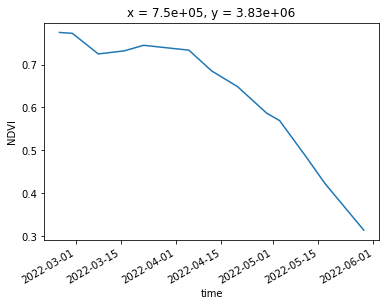

In [5]:
# Calculate a vegetation index through time for a pixel
dsub = dat.sel(x=750_000, y=3_830_000, method="nearest")
dsub.dims
red = dsub.sel(wavelength=660, method="nearest").reflectance
nir = dsub.sel(wavelength=800, method="nearest").reflectance
ndvi = (nir - red) / (nir + red)
ndvi.plot()
plt.ylabel("NDVI")
plt.draw()